In [37]:
import math as mat
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [38]:
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=16

In [39]:
#parameters
g = 9.81            #gracitational acceleration
vt = 4.9            #trim velocity
CD = 1.0/ 5.0       #drag coefficient
CL = 1.0            #ligt coefficient

#initial conditions
v0 = 6.5            #start at the trim velocity
theta0 = -0.1       #trajectory angle
x0 = 0.0            #horizontal position
y0 = 25          #vertical position (altitude)

In [40]:
def rhs_phugoid(u, CL, CD, g, vt):
    v, theta, x, y = u
    rhs = np.array([-g * mat.sin(theta) - CD / CL * g / vt**2 * v**2,
                       -g * mat.cos(theta) / v + g / vt**2 * v,
                       v * mat.cos(theta),
                       v * mat.sin(theta)])
    return rhs

In [41]:
def euler_step(u, f, dt, *args):
    u_new = u + dt * f(u, *args)
    return u_new

In [42]:
def l1_diff(u_coarse, u_fine, dt):
    N_coarse = u_coarse.shape[0]
    N_fine = u_fine.shape[0]
    ratio = mat.ceil(N_fine / N_coarse)
    diff = dt * np.sum(np.abs(u_coarse - u_fine[::ratio]))
    return diff

In [43]:
def rk2_step(u, f, dt, *args):
    u_star = u + 0.5 * dt * f(u, *args)
    u_new = u + dt * f(u_star, *args)
    return u_new

In [44]:
T = 36  # length of the time interval
dt = 0.01  # time-step size
N = int(T / dt) + 1  # number of time steps

# Create arrays to store the solution at each time step.
u_euler = np.empty((N, 4))
u_rk2 = np.empty((N, 4))

# Set the initial conditions.
u_euler[0] = np.array([v0, theta0, x0, y0])
u_rk2[0] = np.array([v0, theta0, x0, y0])

# Time integration with both method.
for n in range(N - 1):
    u_euler[n + 1] = euler_step(u_euler[n], rhs_phugoid, dt,
                                CL, CD, g, vt)
    u_rk2[n + 1] = rk2_step(u_rk2[n], rhs_phugoid, dt,
                            CL, CD, g, vt)

In [45]:
#get the glider's position over the time
x_euler = u_euler[:, 2]
y_euler = u_euler[:, 3]
x_rk2 = u_rk2[:, 2]
y_rk2 = u_rk2[:, 3]

In [46]:
#get the index of the first negative element of y_euler
idx_negative_euler = np.where(y_euler < 0.0)[0]
if len(idx_negative_euler) ==0:    #length of the array is 0
    idx_ground_euler = N - 1   # last index
    print('[Euler]Glider has not touched ground yet!')
else:
    idx_ground_euler = idx_negative_euler[0]
    
#get the index of the first negative element of y_rk2
idx_negative_rk2 = np.where(y_rk2 < 0.0)[0]
if len(idx_negative_rk2) == 0:
    idx_ground_rk2 = N - 1
    print('[RK1] Glider has not toughed ground yet!')
else:
    idx_ground_rk2 = idx_negative_rk2[0]

In [47]:
#check if to two cheme leads to the same numerical solutions
print('Are the x-values close? {}'.format(np.allclose(x_euler, x_rk2)))
print('Are the y-values close? {}'.format(np.allclose(y_euler, y_rk2)))

Are the x-values close? False
Are the y-values close? False


Distance traveled: 128.947


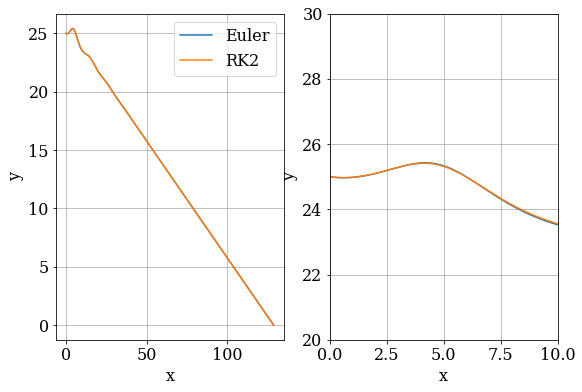

In [53]:
print('Distance traveled: {:.3f}'.format(x_rk2[idx_ground_rk2 - 1]))

# Plot the glider's path for both schemes.
plt.figure(figsize=(9.0, 6.0))
plt.subplot(121)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x_euler[:idx_ground_euler], y_euler[:idx_ground_euler],
            label='Euler')
plt.plot(x_rk2[:idx_ground_rk2], y_rk2[:idx_ground_rk2],
            label='RK2')
plt.legend();

# Let's take a closer look!
plt.subplot(122)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x_euler, y_euler, label='Euler')
plt.plot(x_rk2, y_rk2, label='RK2')
plt.xlim(0.0, 10)
plt.ylim(20, 30);

In [54]:
#set the list of time-step sizes to investigate
dt_values = [0.1, 0.05, 0.01, 0.005, 0.001]

#create an empty list to store the solution for each time-step size
u_values = []

for dt in dt_values:
    N = int(T/dt) + 1
    
    #initial conditions
    u = np.empty((N, 4))
    u[0] = np.array([v0, theta0, x0, y0])
    
    #time integration using RK2 method
    for n in range(N - 1):
        u[n + 1] = rk2_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)
    u_values.append(u)

In [55]:
#compute the differences in the x-position for all grids
diff_values = []
for u, dt in zip(u_values, dt_values):
    diff = l1_diff(u[:, 2], u_values[-1][:, 2], dt)
    diff_values.append(diff)

(0.004304458296658676,
 0.11615863496415428,
 0.00023807268554643213,
 0.09159557154719004)

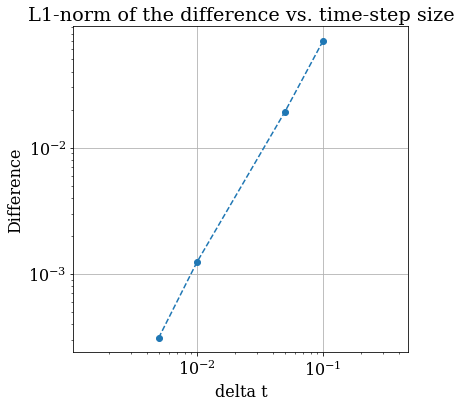

In [56]:
#plot difference versus the time-step size
plt.figure(figsize=(6.0, 6.0))
plt.title('L1-norm of the difference vs. time-step size')
plt.xlabel('delta t')
plt.ylabel('Difference')
plt.grid()
plt.loglog(dt_values[:-1], diff_values[:-1], linestyle='--', marker='o')
plt.axis('equal')

In [57]:
r = 2
h = 0.001

dt_values = [h, r * h, r**2 * h]
u_values = []

for dt in dt_values:
    N = int(T / dt) + 1
    
    # Set initial conditions
    u = np.empty((N, 4))
    u[0] = np.array([v0, theta0, x0, y0])
    # Time integration using RK2.
    for n in range(N - 1):
        u[n + 1] = rk2_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)
        
    # Store the solution for the present time grid
    u_values.append(u)

# Compute the observed order of convergence
p = (mat.log(l1_diff(u_values[2], u_values[1], dt_values[2]) /
              l1_diff(u_values[1], u_values[0], dt_values[1])) /
     mat.log(r))

print('Observed order of convergence: p = {:.3f}'.format(p))

Observed order of convergence: p = 1.989


In [63]:
def leapfrog_step(u_prev, u, f, dt, *args):
    u_new = u_prev + 2.0 * dt * f(u, *args)
    return u_new

In [66]:
#parameters
g = 9.81                 # gravitational acceleration
vt = 4.9                 # trim velocity
CD = 1.0 / 5.0           # drag coefficient
CL = 1.0                 # lift coefficient

#initial conditions.
v0 = 6.5                 # start at the trim velocity
theta0 = -0.1            # trajectory angle
x0 = 0.0                 # horizontal position
y0 = 25                 # vertical position (altitude)

T = 36                 # length of the time interval
dt = 0.01                # time-step size
N = int(T / dt) + 1      # number of time steps

# Create arrays to store the solution at each time step
u_leapfrog = np.empty((N, 4))

#initial conditions
u_leapfrog[0] = np.array([v0, theta0, x0, y0])

# Use the RK2 method for the first time step
u_leapfrog[1] = rk2_step(u_leapfrog[0], rhs_phugoid, dt, CL, CD, g, vt)

In [67]:
# Time integration using the leapfrog method
for n in range(1, N - 1):
    u_leapfrog[n + 1] = leapfrog_step(u_leapfrog[n - 1], u_leapfrog[n],
                                      rhs_phugoid, dt, CL, CD, g, vt)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: math domain error

In [68]:
# Get the glider's position over the time
x_leapfrog = u_leapfrog[:, 2]
y_leapfrog = u_leapfrog[:, 3]

# Get the index of the first negative element of y_leapfrog
idx_negative_leapfrog = np.where(y_leapfrog < 0.0)[0]
if len(idx_negative_leapfrog) == 0:
    idx_ground_leapfrog = N - 1
    print('[leapfrog] Glider has not touched ground yet!')
else:
    idx_ground_leapfrog = idx_negative_leapfrog[0]

Distance traveled: 123.917


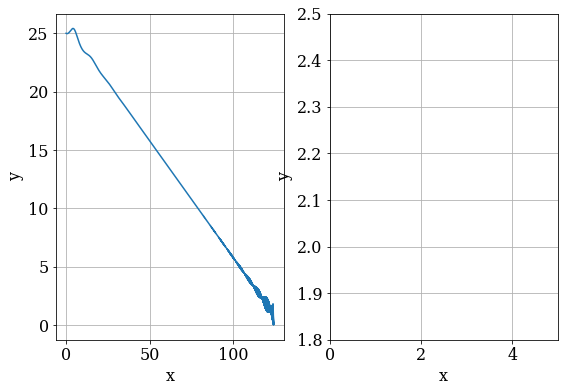

In [69]:
print('Distance traveled: {:.3f}'.format(x_leapfrog[idx_ground_leapfrog - 1]))

# Plot the glider's path for the leapfrog scheme
plt.figure(figsize=(9.0, 6.0))
plt.subplot(121)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x_leapfrog[:idx_ground_leapfrog],
            y_leapfrog[:idx_ground_leapfrog])

# Let's take a closer look!
plt.subplot(122)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x_leapfrog, y_leapfrog)
plt.xlim(0.0, 5.0)
plt.ylim(1.8, 2.5);

In [70]:
r = 2
h = 0.001

dt_values = [h, r * h, r**2 * h]
u_values = []

for dt in dt_values:
    N = int(T / dt) + 1
    # Set initial conditions.
    u = np.empty((N, 4))
    u[0] = np.array([v0, theta0, x0, y0])
    # Use RK2 for the first time step.
    u[1] = rk2_step(u[0], rhs_phugoid, dt, CL, CD, g, vt)
    
    # Time integration using the leapfrog scheme.
    for n in range(1, N - 1):
        u[n + 1] = leapfrog_step(u[n - 1], u[n], rhs_phugoid, dt,
                                 CL, CD, g, vt)
    # Store the solution for the present time grid.
    u_values.append(u)

# Compute the observed order of convergence.
p = (mat.log(l1_diff(u_values[2][:, 2], u_values[1][:, 2],
                      dt_values[2]) /
              l1_diff(u_values[1][:, 2], u_values[0][:, 2],
                      dt_values[1])) /
     mat.log(r))

print('Observed order of convergence: p = {:.3f}'.format(p))

Observed order of convergence: p = 4.181
